## Batch Prediction 
To preprocess entire datasets quickly or to get inferences from a trained model for large datasets when you don't need a persistent endpoint, Batch Transform is preferred way to deploy model.
Batch Transform manages all necessary compute resources, including launching instances to deploy endpoints and deleting them afterward.


In [1]:
default_bucket = "sagemaker-us-west-1-055338534628/customer-churn-ml-prediction/telco_churn_data"
batch_input = 's3://{}/batch/test_input.csv'.format(default_bucket) # test data used for prediction
batch_output = 's3://{}/batch/test-batch-inference.csv'.format(default_bucket) 


In [2]:
import pandas as pd

# popping ground truth label from test set we saved in "data_analysis_&_prep.ipynb"
test_set = pd.read_csv('s3://{}/test/test.csv'.format(default_bucket), header=None)
ground_truth_test = test_set.iloc[:, :1]
test_input_batch = test_set.iloc[:, 1:]
test_input_batch.to_csv('s3://{}/batch/test_input.csv'.format(default_bucket), header=False, index=False)

In [3]:
test_input_batch.head()

,1,2,3,4,5,6,7,8,9,10,...,37,38,39,40,41,42,43,44,45,46
0,69,81.95,5601.40,0,1,1,0,0,1,0,...,1,0,0,1,0,1,1,0,0,0
1,33,80.10,2603.30,0,1,1,0,1,0,1,...,0,0,1,0,1,0,1,0,0,0
2,46,21.10,937.10,1,0,1,0,1,0,1,...,0,0,0,1,0,1,0,0,1,0
3,1,69.60,69.60,1,0,0,1,1,0,1,...,0,1,0,0,0,1,0,0,1,0
4,1,75.55,75.55,1,0,1,0,1,0,1,...,0,1,0,0,1,0,0,0,1,0


In [5]:
from time import gmtime, strftime

Modelname = 'Customer-Churn-Classification' # the model name we already 
transformJobName = 'xgboost-churn-call-batch'+ strftime("%Y-%m-%d-%H-%M-%S", gmtime())


In [6]:
import boto3
client = boto3.client('sagemaker')


In [7]:
create_batch = client.create_transform_job(
    TransformJobName=transformJobName,
    ModelName=Modelname,
    MaxConcurrentTransforms=0,
    MaxPayloadInMB=6,
    BatchStrategy='MultiRecord',
    TransformInput={
        'DataSource': {
            'S3DataSource': {
                'S3DataType': 'S3Prefix',
                'S3Uri': batch_input 
            }
        },
        'ContentType': 'text/csv',
        'CompressionType': 'None',
        'SplitType': 'Line'
    },
    TransformOutput={
        'S3OutputPath': batch_output,
        'AssembleWith': 'Line'
    },
    TransformResources={
        'InstanceType': 'ml.m4.xlarge',
        'InstanceCount': 1
    }
    )

In [73]:
batch_output = 's3://{}/batch/test-batch-inference.csv/test_input.csv.out'.format(default_bucket) 
batch_pred = pd.read_csv(batch_output, header=None, encoding = "ISO-8859-1") # header = none


## Evaluating Predictions

In [120]:
import numpy as np

pred_y = np.round(batch_pred) # threshold is 0.5


In [121]:
from sklearn import metrics

def get_score(y_true,y_pred):
    f1 = metrics.f1_score(y_true, y_pred)
    precision = metrics.precision_score(y_true, y_pred)
    recall = metrics.recall_score(y_true, y_pred)
    accuracy = metrics.accuracy_score(y_true, y_pred)
    tn, fp, fn, tp = metrics.confusion_matrix(y_true, y_pred).ravel()
    return precision, recall, f1, accuracy, tn, fp, fn, tp

In [122]:
pred_y.size

705

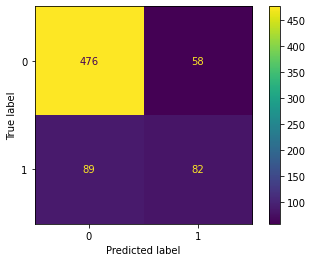

In [133]:
from sklearn.metrics import ConfusionMatrixDisplay 
import matplotlib.pyplot as plt

cm = metrics.confusion_matrix(ground_truth_test, pred_y)
confusion_matrix = ConfusionMatrixDisplay(confusion_matrix=cm)
confusion_matrix.plot()

In [124]:
precision, recall, f1, acc, tn, fp, fn, tp = get_score(ground_truth_test,pred_y)
print("Precision = ", precision)
print("Recall = ", recall)
print("F1-score = ", f1)
print("Accuracy = ", acc)
print("True Positive = ", tp)
print("True Negative = ", tn)
print("False Postive = ", fp)
print("False Negative = ", fn)


Precision =  0.5857142857142857
Recall =  0.47953216374269003
F1-score =  0.5273311897106109
Accuracy =  0.7914893617021277
True Positive =  82
True Negative =  476
False Postive =  58
False Negative =  89


Out of 140 churned customers predicted, we were able to predict 82 of them (true positive) correctly. And we incorrectly predicted 58 customers who ended up not doing so (false postive). 
There were 89 customers who ended up churning, that we predicted would not (false negative).

An important point here is that because of the np.round() function above we are using a simple threshold (or cutoff) of 0.5. Our predictions from xgboost come out as continuous values between 0 and 1 and we force them into the binary classes that we began with. However, because a customer that churns is expected to cost the company more than proactively trying to retain a customer who we think might churn, we should consider adjusting this cutoff. That will almost certainly increase the number of false positives, but it can also be expected to increase the number of true positives and reduce the number of false negatives.

To get a rough intuition here, let's look at the continuous values of our predictions.



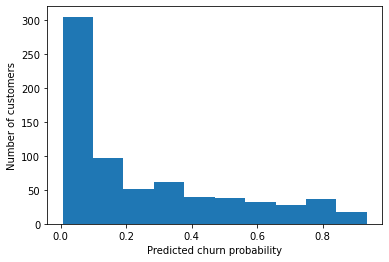

In [95]:
plt.hist(batch_pred)
plt.xlabel("Predicted churn probability")
plt.ylabel("Number of customers")
plt.show()

Whereas if we apply a cutoff of 0.5, the binary predictions have histogram as shown below

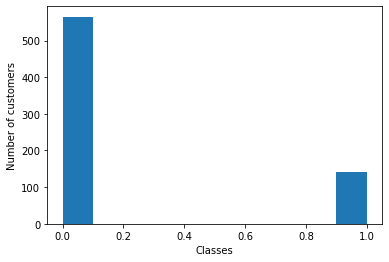

In [126]:
plt.hist(pred_y)
plt.xlabel("Classes")
plt.ylabel("Number of customers")
plt.show()


In [131]:
pred_y.value_counts()

0.0    565
1.0    140
dtype: int64

As we can see from the histogram of batch predictions, there is sufficient mass between 0.1 and 0.9 , so adjusting the cutoff should indeed shift a number of customers' predictions. Lets try a threshold of 0.3  and see how the confusion matrix changes.

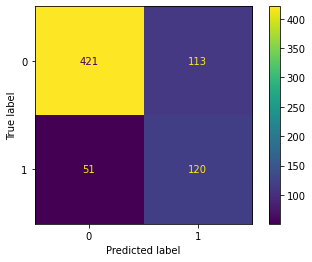

In [113]:
import numpy as np

pred_y = np.where(batch_pred > 0.3, 1, 0)
cm = metrics.confusion_matrix(ground_truth_test, pred_y)
confusion_matrix = ConfusionMatrixDisplay(confusion_matrix=cm)
confusion_matrix.plot()

In [114]:
precision, recall, f1, acc, tn, fp, fn, tp = get_score(ground_truth_test,pred_y)
print("Precision = ", precision)
print("Recall = ", recall)
print("F1-score = ", f1)
print("Accuracy = ", acc)
print("True Positive = ", tp)
print("True Negative = ", tn)
print("False Postive = ", fp)
print("False Negative = ", fn)


Precision =  0.5150214592274678
Recall =  0.7017543859649122
F1-score =  0.594059405940594
Accuracy =  0.7673758865248227
True Positive =  120
True Negative =  421
False Postive =  113
False Negative =  51


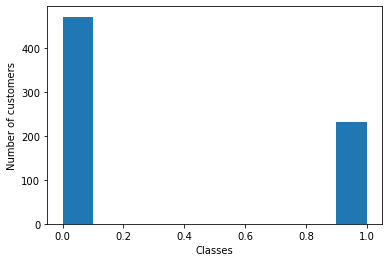

In [100]:
plt.hist(pred_y)
plt.xlabel("Classes")
plt.ylabel("Number of customers")
plt.show()

Lowering the cutoff threshold from 0.5 to 0.3 results in 38 more true postives, 55 more false postive and 38 fewer false negatives.
Altough we end up retaining 38 more customers, we are also unnecessarily incentivizing 55 more customers who would have stayed anyway.
Determining optimal cutoffs is a key step in properly applying machine learning in a real-world setting. Let's discuss this more broadly and then apply a specific, hypothetical solution for our current problem.

## Relative cost of errors


Any practical binary classification problem is likely to produce a similarly sensitive cutoff. That by itself isn’t a problem. After all, if the scores for two classes are really easy to separate, the problem probably isn’t very hard to begin with and might even be solvable with deterministic rules instead of ML.

More important, if we put an ML model into production, there are costs associated with the model erroneously assigning false positives and false negatives. We also need to look at similar costs associated with correct predictions of true positives and true negatives. Because the choice of the cutoff affects all four of these statistics, we need to consider the relative costs to the business for each of these four outcomes for each prediction.



### Assigning costs

What are the costs for our problem of mobile operator churn? The costs, of course, depend on the specific actions that the business takes. Let's make some assumptions here.

First, assign the true negatives the cost of $0. Our model essentially correctly identified a happy customer in this case, and we don’t need to do anything.

False negatives are the most problematic, because they incorrectly predict that a churning customer will stay. We lose the customer and will have to pay all the costs of acquiring a replacement customer, including foregone revenue, advertising costs, administrative costs, point of sale costs, and likely a phone hardware subsidy. A quick search on the Internet reveals that such costs typically run in the hundreds of dollars so, for the purposes of this example, let's assume $500. This is the cost of false negatives.

Finally, for customers that our model identifies as churning, let's assume a retention incentive in the amount of \\$100. If a provider offered a customer such a concession, they may think twice before leaving. This is the cost of both true positive and false positive outcomes. In the case of false positives (the customer is happy, but the model mistakenly predicted churn), we will waste the $100 concession. We probably could have spent that \\$100 more effectively, but it's possible we increased the loyalty of an already loyal customer, so that’s not so bad.




## Finding the optimal cutoff
It’s clear that false negatives are substantially more costly than false positives. Instead of optimizing for error based on the number of customers, we should be minimizing a cost function that looks like this:

    $500 * FN(C) + $0 * TN(C) + $100 * FP(C) + $100 * TP(C)

FN(C) means that the false negative percentage is a function of the cutoff, C, and similar for TN, FP, and TP. We need to find the cutoff, C, where the result of the expression is smallest.

A straightforward way to do this is to simply run a simulation over numerous possible cutoffs. We test 100 possible values in the for-loop below.

In [163]:

# pd.crosstab(index=test_set.iloc[:, 0], columns = pred_y)
len(pred_y)

705

/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ec2-user/anaconda3/envs/python3/lib/python3

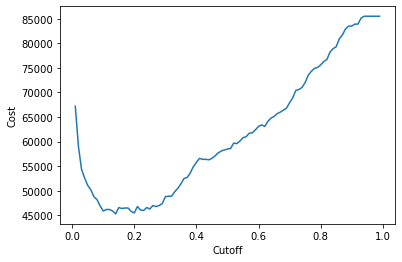

In [166]:
cutoffs = np.arange(0.01, 1, 0.01)
costs = []

for c in cutoffs:
    pred_y = [item for sublist in np.where(batch_pred > c, 1, 0) for item in sublist]
    _, _, _, _, tn, fp, fn, tp = get_score(ground_truth_test,pred_y)
    costs.append(
        np.sum(
            np.sum(
                np.array([[0, 100], [500, 100]])
                * np.array([[tn, fp], [fn, tp]])
            )
        )
    )

costs = np.array(costs)
plt.plot(cutoffs, costs)
plt.xlabel("Cutoff")
plt.ylabel("Cost")
plt.show()

In [167]:
print(
    "Cost is minimized near a cutoff of:",
    cutoffs[np.argmin(costs)],
    "for a cost of:",
    np.min(costs),
)

Cost is minimized near a cutoff of: 0.14 for a cost of: 45300


The above chart shows how picking a threshold too low results in costs skyrocketing as all customers are given a retention incentive. Meanwhile, setting the threshold too high results in too many lost customers, which ultimately grows to be nearly as costly. The overall cost can be minimized at $45300 by setting the cutoff to 0.14.